In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append("../src")
from tb import *
from hamiltonians import *

# Check 1: just check that dimer model is working

In [3]:
N = 20
Norb = 2
Nb = 2
Nk = N // Norb
H = oned_chain_hamiltonian(N, J=1, dimer=0.2)#.reshape((1,1,N,N))
a = np.array([[2]])
T = (np.arange(Nk) * a).reshape((Nk, 1))
b = 2*np.pi*np.linalg.inv(a)
k = get_kpt_mesh((Nk,), b)

basis = np.eye(N).reshape((len(T), 2, N)).transpose((0,2,1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)

P = get_momentum_operator(chik, k[:, 0])
Hk = np.einsum("kim,ij,kjn->kmn", chik.conj(), H, chik)
es = np.linalg.eigvalsh(Hk)

Hk = oned_chain_k_hamiltonian(k, a[0], J=1, h=0, dimer=.2)
e_exact = np.linalg.eigvalsh(Hk)

In [4]:
def get_exact_energy(ka, J=1, delta=.2):
    return 2*J*np.sqrt(1 - (1-delta*delta)*np.sin(ka)*np.sin(ka))

In [5]:
E = get_exact_energy(np.linspace(0, np.pi, 100))

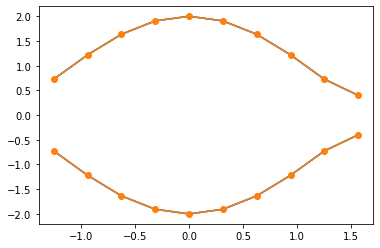

In [6]:
plt.plot(k, e_exact, c='C0')
plt.plot(k, -e_exact, c='C0')

plt.plot(k, es, "-o", c='C1')

# Check 2: Switch to cluster basis and relabel, no truncation yet

Let $H$ be the normal Hamiltonian, which we can divide into $N_b$ clusters and we can diagonalize each of these. 

In [7]:
N = 32
Norb = 2
Nb = 1

dimer = .05
Nk = N // Norb
H = oned_chain_hamiltonian(N, J=1, dimer=dimer)#.reshape((1,1,N,N))
a = np.array([[2]])
T = (np.arange(Nk) * a).reshape((Nk, 1))
b = 2*np.pi*np.linalg.inv(a)
k = get_kpt_mesh((Nk,), b)

basis = np.eye(N).reshape((len(T), 2, N)).transpose((0,2,1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)

P = get_momentum_operator(chik, k[:, 0])
Hk = np.einsum("kim,ij,kjn->kmn", chik.conj(), H, chik)
es = np.linalg.eigvalsh(Hk)

In [8]:
hcluster = oned_chain_hamiltonian(N//Nb, J=1, dimer=dimer)
_, u = np.linalg.eigh(hcluster)
q, r = np.linalg.qr(u)
U = get_block_transformation_matrix(q, Nb)
#U = np.block([[q, np.zeros(q.shape)],[np.zeros(q.shape), q]])

kp, ep, V = basis_transform_and_relabel(H, [P], U, Norb=2)

assert np.allclose(kp.imag, 0.0)
kp = kp.real
print(q.shape)

(32, 32)


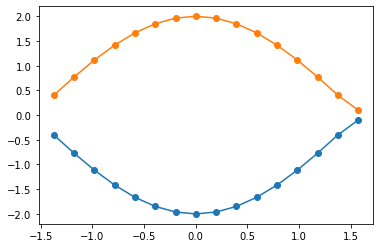

In [10]:
plt.plot(k, es)
for i in range(2):
    plt.scatter(kp.ravel(), ep[:, i])

# Check 3: What happens when we start to truncate things? note this is a really bad hamiltonian bc nothing at fermi level

## With truncation

In [22]:
N = 32
Norb = 2
Nb = 4

dimer = .05
Nk = N // Norb # N unit cells

H = oned_chain_hamiltonian(N, J=1, dimer=dimer)#.reshape((1,1,N,N))
a = np.array([[2]])
T = (np.arange(Nk) * a).reshape((Nk, 1))
b = 2*np.pi*np.linalg.inv(a)
k = get_kpt_mesh((Nk,), b)

basis = np.eye(N).reshape((len(T), 2, N)).transpose((0,2,1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)

P = get_momentum_operator(chik, k[:, 0])
Hk = np.einsum("kim,ij,kjn->kmn", chik.conj(), H, chik)
es = np.linalg.eigvalsh(Hk)

In [23]:
hcluster = oned_chain_hamiltonian(N//Nb, J=1, dimer=dimer, bc=1)
ep, up = np.linalg.eigh(hcluster)

hcluster = oned_chain_hamiltonian(N//Nb, J=1, dimer=dimer, bc=-1)
ea, ua = np.linalg.eigh(hcluster)
e_cutoff = 1

up = up[:, np.abs(ep) < e_cutoff]
ua = ua[:, np.abs(ea) < e_cutoff]

q, r = np.linalg.qr(np.hstack([up, ua]))

U = get_block_transformation_matrix(q, Nb)

kp, ep, _ = basis_transform_and_relabel(H, [P], U, Norb=2)


assert np.allclose(kp.imag, 0.0)
kp = kp.real
print(U.shape)

(32, 24)


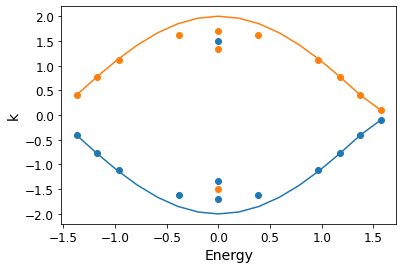

In [24]:
plt.plot(k, es)
for i in range(2):
    plt.scatter(kp, ep[:, i])
plt.xlabel("Energy", fontsize=14)
plt.ylabel("k", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("img/dimerized_pbc.png", bbox_inches='tight')